# SHAP解释广告点击预测模型



## Shapley值是什么？

Shapley值是博弈论中使用的一种方法，它涉及公平地将收益和成本分配给在联盟中工作的行动者。

由于每个行动者对联盟的贡献是不同的，Shapley值保证每个行动者根据贡献的多少获得公平的份额。
![](img/贡献.png)

Shapley值被广泛地应用于求解群体中每个工人(特征)的贡献问题，能起到特征权重测度的作用。

## SHAP解释广告点击预测模型原理

首先训练一个机器学习模型来预测广告是否被特定的人点击。在收到关于某人的一些信息后，模型预测某人不会点击广告。

如果我们想要知道不同广告策略中每种广告对收入的贡献值，我们就可以采用Shapley值的计算方法。

每个策略在特定月份的收入是：

- 无广告：150美元
- 社交媒体：300美元
- 谷歌广告：200美元
- 电子邮件营销：350美元
- 社交媒体和谷歌广告：320美元
- 社交媒体和电子邮件营销：400美元
- 谷歌广告和电子邮件营销：350美元
- 电子邮件营销，谷歌广告和社交媒体：450美元

![](img/策略营收.png)

使用三则广告与不使用广告的收入相差300美元，每则广告对这一差异有多大的贡献?

![](img/策略营收贡献几何.png)

我们可以通过计算每一类广告的Shapley值来计算谷歌广告对公司收入的总贡献入手，通过公式可以计算出Google广告的总贡献：

![](img/公式.png)

### 寻找谷歌广告的边际贡献

第一，我们将发现谷歌广告对以下群体的边际贡献：

- 无广告
- 谷歌广告+社交媒体
- 谷歌广告+电子邮件营销
- 谷歌广告+电子邮件营销+社交媒体

![](img/边际贡献.png)

Google广告 对 无广告 的边际贡献是：

![](img/MC1.png)

谷歌广告 对 谷歌广告&社交媒体组合 的边际贡献是：

![](img/MC2.png)

谷歌广告 对 谷歌广告&电子邮件营销组合 的边际贡献是：

![](img/MC3.png)

谷歌广告 对 谷歌广告、电子邮件营销和社交媒体组合 的边际贡献是：

![](img/MC4.png)

### 发现权重

为了发现权重，我们将把不同广告策略的组合组织成如下多个层次，每个层次对应于每个组合中广告策略的数量。

然后根据每个层次的边数分配权重，我们看到了这一点：

- 第一级包含3条边，因此每个边的权重为1/3
- 第二级包含6条边，因此每条边的权重将为1/6
- 第三级包含3条边，因此每条边的权重将为1/3

![](img/发现权重.png)

### 发现Google广告的总贡献

根据前面的权重和边际贡献，我们已经可以找到Google广告的总贡献!

![](img/google总贡献.png)


![](img/google公式.png)

酷!所以谷歌广告在使用3种广告策略与不使用广告的总收入差异中贡献了36.67美元。36.67是Google广告的Shapey值。

![](img/otherRevenue.png)

重复以上步骤，对于另外两种广告策略，我们可以看出：

- 电子邮件营销贡献151.67美元
- 社交媒体贡献116.67美元
- 谷歌广告贡献36.67美元

![](img/各策略贡献.png)





## python实现
SHAP是一个 Python 库，它使用 Shapley 值来解释任何机器学习模型的输出。
安装shap

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\cmy\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


## 训练模型
为了理解SHAP工作原理，我们使用Kaggle平台内的advertising广告数据集。

In [2]:
import pandas as pd 

df = pd.read_csv("advertising.csv")
df.head()

,daily_time_spent_on_site,age,area_income,daily_internet_usage,ad_topic_line,city,male,country,timestamp,clicked_on_ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


先建立一个机器学习模型, 该模型根据用户个人特质信息来预测其是否点击广告。
使用Patsy将DataFrame转换为一组特征和一组目标值：

In [3]:
pip install future

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\cmy\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [4]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split

y, X = dmatrices(
    "clicked_on_ad ~ daily_time_spent_on_site + age + area_income + daily_internet_usage  + male -1",
    data=df,
)

X_frame = pd.DataFrame(data=X, columns=X.design_info.column_names)



把数据分为测试集和训练集

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

接下来使用XGBoost训练模型，并做预测

In [6]:
import xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)
y_predicted = model.predict(X_test)

c:\users\cmy\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\cmy\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\cmy\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[15:17:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


为了查看模型表现，我们使用F1得分

In [7]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_predicted)
f1

0.9619047619047619

## 解释该模型
该模型很好地预测了用户是否点击广告。但它是如何得出这样的预测的? **每个特征对最终预测与平均预测的差异贡献了多少?**

注意，这个问题与我们在文章开头论述的问题非常相似。

因此，寻找每个特征的Shapley值可以帮助我们确定它们的贡献。得到特征i的重要性的步骤与之前类似，其中i是特征的索引：

- 获取所有不包含特征i的子集
- 找出特征i对这些子集中每个子集的边际贡献
- 聚合所有边际贡献来计算特征i的贡献

若要使用SHAP查找Shapley值，只需将训练好的模型插入shap.Explainer

In [8]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_frame)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## SHAP瀑布图
可视化第一个预测的解释：

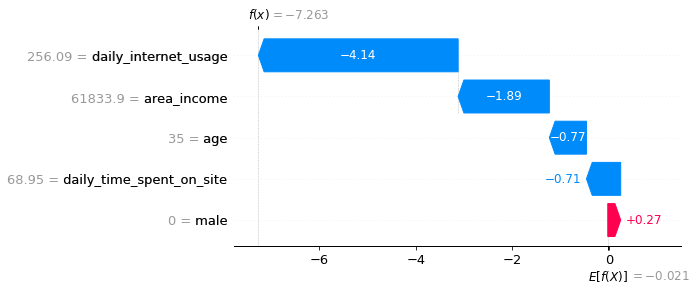

In [9]:
#第一条记录是未点击
shap.plots.waterfall(shap_values[0])

现在我们知道每个特征对第一次预测的贡献。对上图的解释：

![](img/第一次预测贡献.png)

- 蓝色条显示某一特定特征在多大程度上降低了预测的值。
- 红条显示了一个特定的特征在多大程度上增加了预测值。
- 负值意味着该人点击广告的概率小于0.5

我们应该期望总贡献等于预测与均值预测的差值。我们来验证一下：

![](img/总贡献等于预测与均值预测的差值.png)

验证成功！

可视化第二个预测的解释：

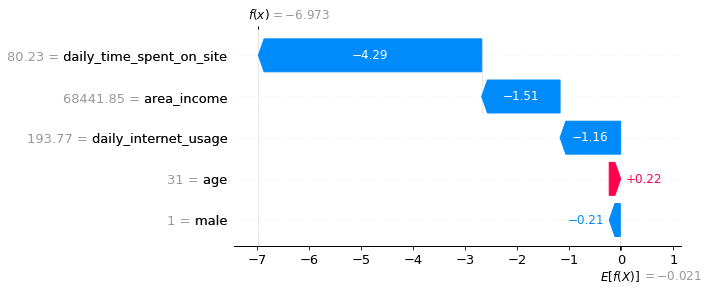

In [10]:
#第二条记录也是未点击
shap.plots.waterfall(shap_values[1])

## SHAP摘要图
我们可以使用SHAP摘要图，而不是查看每个单独的实例，来可视化这些特性对多个实例的整体影响：

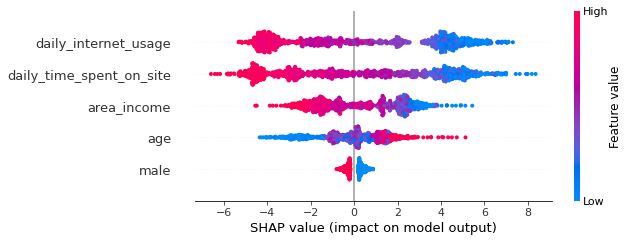

In [11]:
shap.summary_plot(shap_values, X)

SHAP摘要图告诉我们数据集上最重要的特征及其影响范围。

从上面的情节中，我们可以对模型的预测获得一些有趣的见解：
- 用户的 **daily_internet_usage** 对该用户是否点击广告的影响最大。
- 随着**daily_time_spent_on_site**的增加，用户点击广告的可能性降低。
- 随着**area_income**的增加，用户点击广告的可能性降低。
- 随着**age**的增长，用户更容易点击广告。
- 如果用户是**male**，则该用户点击广告的可能性较小。

## SHAP条形图
我们还可以使用SHAP条形图得到全局特征重要性图。

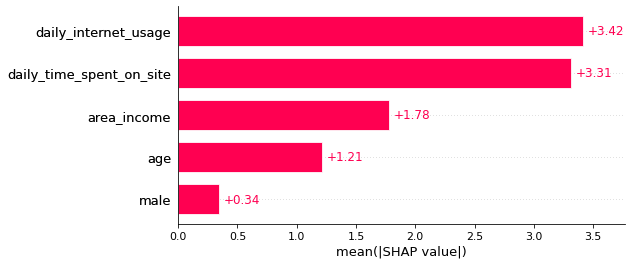

In [12]:
shap.plots.bar(shap_values)

## SHAP 依赖散点图
我们可以使用 SHAP 依赖散点图观察单个特征对模型所做的所有预测的影响。
日常互联网使用
每日互联网使用特征的散点图：

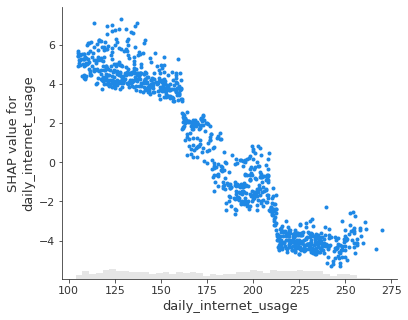

In [13]:
shap.plots.scatter(shap_values[:, "daily_internet_usage"])

从上图中，我们可以看到，随着每日互联网使用量的增加，每日互联网使用量的 SHAP 值会下降。这证实了我们在前面的图中看到的内容。
我们还可以通过添加 来观察日常互联网使用特征与同一图中其他特征之间的相互作用color=shap_values。
散点图将尝试挑选出与日常互联网使用交互最强的特征列，即每天在网站上花费的时间。

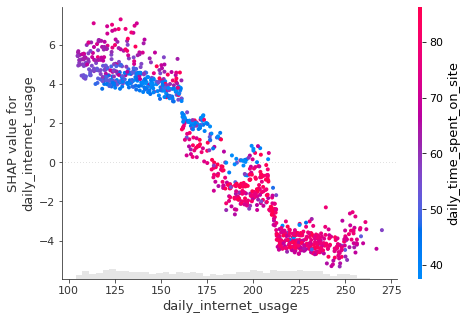

In [14]:
shap.plots.scatter(shap_values[:, "daily_internet_usage"], color=shap_values)

## SHAP 交互图
我们还可以使用 SHAP 交互值汇总图观察特征之间的交互矩阵。


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


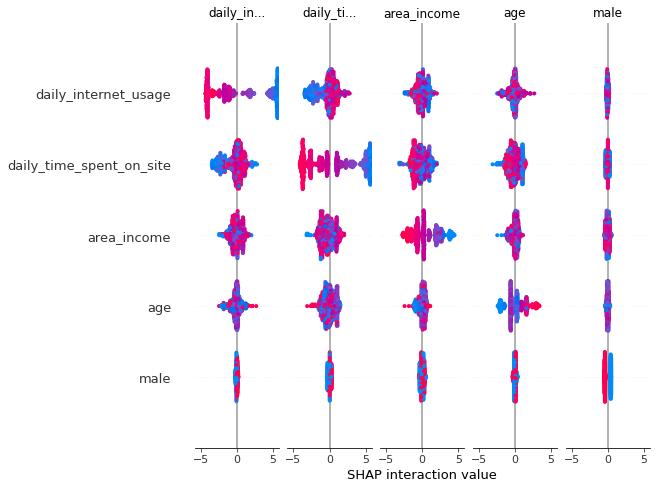

In [15]:
# Get interaction values
shap_interaction_values = explainer.shap_interaction_values(X)

# Summarize the interaction values
shap.summary_plot(shap_interaction_values, X_frame)

## 实验总结
上面案例运用shapley值的计算方法的原理，使用python中的SHAP库，解释了广告点击预测模型。使用python中的SHAP库的主要优点是，当将 Shapley 值应用于机器学习时，它能够更有效地计算 Shapley 值。可以看出，shapley值在机器学习模型可解释性的应用上效果很好。
